## Rain EDA Notebook
### Dylan M Jones
### Feb 13, 2021

This notebook is to examine the structure of a weather dataset from kaggle. It contains the weather data from various stations in Australia, with the objective of building a model to predict precipitation the following day.

This dataset looks fun, because we can start with initial assumptions and check whether they hold true with exploration of the variables. It also lays a foundation for possibly asking new questions using the data, or including new external data to the set as we dive deeper and which to enhance the performance of the model.

## Table of Contents

1. [Inspiration](#1)
1. [Data exploration](#2)
    -  [Univariate Analysis](#2.1)
    -  [Bivariate Analysis](#2.2)
    -  [Multivariate Analysis](#2.3)
1. [Feature Engineering](#3)
    -   [Numerical Feature Engineering](#3.1)
    -   [Categorical Feature Engineering](#3.2)
1. [Model Training and Output](#4)
1. [Model Performance Assessment](#5)
    -   [Accuracy vs Recall vs Sensitivity](#5.1)
1. [Enhancing the Dataset](#6)
    -   [Geocoding Locations](#6.1)
    -   [Gathering topology](#6.2)
    -   [Wind direction encoding](#6.3)
    -   [New feature analysis](#6.4)
    -   [New model training](#6.5)
1. [Conclusions](#7)

## 1. Inspiration <a class="anchor" id = "1"></a>

In [252]:
## Initial library setup

import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split 
%matplotlib inline
from sklearn import preprocessing


## Load data
rawWeather = pd.read_csv("weatherAUS.csv")


In [253]:
## Check table
rawWeather['Date'] = pd.to_datetime(rawWeather['Date'])
rawWeather['Month'] = rawWeather['Date'].dt.month
rawWeather['Day'] = rawWeather['Date'].dt.day
rawWeather['Year'] = rawWeather['Date'].dt.year
rawWeather['Weekday'] = rawWeather['Date'].dt.strftime('%A')
rawWeather.drop(['Date'], axis = 1, inplace = True)


print("Dataset dimensions: " + str(rawWeather.shape) + "\n")
print("Dataset variables: " + str(rawWeather.columns))

# print(rawWeather.info())

Dataset dimensions: (145460, 26)

Dataset variables: Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month', 'Day', 'Year',
       'Weekday'],
      dtype='object')


This looks promising. We can see that there are 145,460 rows, and 22 columns ( + 4 date columns). 25 columns are fields we can use to try and predict the last column ('RainTomorrow').

Let's check how the target variable looks.


In [254]:
print(rawWeather['RainTomorrow'].value_counts())


print("\nRain occurs " + str(round(len(rawWeather[rawWeather['RainTomorrow'] == 'Yes'])/len(rawWeather),4)*100) + " percent of the time\n")



No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

Rain occurs 21.91 percent of the time



I see a categorical output of "Yes" for rain, and "No" for no rain. So far, so good. We should check for missing values before proceeding.

In [255]:
print("Target variable missing from "+ str(rawWeather['RainTomorrow'].isnull().sum()) +" rows")

Target variable missing from 3267 rows


Uh oh. There are a few cases where the target variable is not present. Since the purpose of the model is to predict rain, and the missing variables don't appear to incidate some hidden category, we are going to drop these cases from the the training and test sets before moving forward.

In [256]:
rawWeather.dropna(subset = ['RainTomorrow'], axis = 0, inplace = True)

print("\nNew dimensions: "+ str(rawWeather.shape)  + "\n")


New dimensions: (142193, 26)



The text encoding of the target will also cause troubles down the line, so setting the target to binary before we get started.

In [257]:
labbin = preprocessing.LabelBinarizer()
rawWeather['RainToday'] = rawWeather['RainToday'].astype(str)
rawWeather['RainToday'] = labbin.fit_transform(rawWeather['RainToday'])
rawWeather['RainTomorrow'] = rawWeather['RainTomorrow'].astype(str)
rawWeather['RainTomorrow'] = labbin.fit_transform(rawWeather['RainTomorrow'])

Before we move much further in the EDA, we should split the dataset to ensure an unbiased validation process

In [258]:
X_train, X_test, y_train, y_test = train_test_split(rawWeather.loc[:,rawWeather.columns != 'RainTomorrow'],rawWeather.loc[:,'RainTomorrow'], test_size = 0.3, random_state = 42)

print('X_train is: ' + str(X_train.shape))
print('y_train is: ' + str(y_train.shape))
print('X_test is: ' + str(X_test.shape))
print('y_test is: ' + str(y_test.shape))

df_train = pd.concat([X_train, y_train], axis = 1)

X_train is: (99535, 25)
y_train is: (99535,)
X_test is: (42658, 25)
y_test is: (42658,)


In [259]:
print("Training set dimensions: \n" + str(df_train.shape)+ "\n")
print("Data types:\n"+ str(df_train.dtypes)+ "\n")

Training set dimensions: 
(99535, 26)

Data types:
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday          int32
Month              int64
Day                int64
Year               int64
Weekday           object
RainTomorrow       int32
dtype: object



It looks like the dataset is part categorical variables, part numerical variables. We will use decision trees as the basis of our models, so both types are accepted. However, these features are treated differently for data cleaning and feature engineering purposes, so we will separate them now.

In [260]:
categorical = [var for var in df_train.columns if df_train[var].dtype == 'O' if var != 'RainTomorrow']
numerical = [var for var in df_train.columns if df_train[var].dtype != 'O' if  var not in ['Day','Month','Year','RainToday','RainTomorrow']]
print("Categorical variables: \n" + str(categorical) + "\n")
print("Numerical variables: \n" + str(numerical) + "\n")

Categorical variables: 
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Weekday']

Numerical variables: 
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']



## 2. Data Exploration<a class="anchor" id = "2"></a>

### 2.1. Univariate analysis <a class="anchor" id = "2.1"></a>

Let's look at some of the numerical variable disributions, to see what we are dealing with

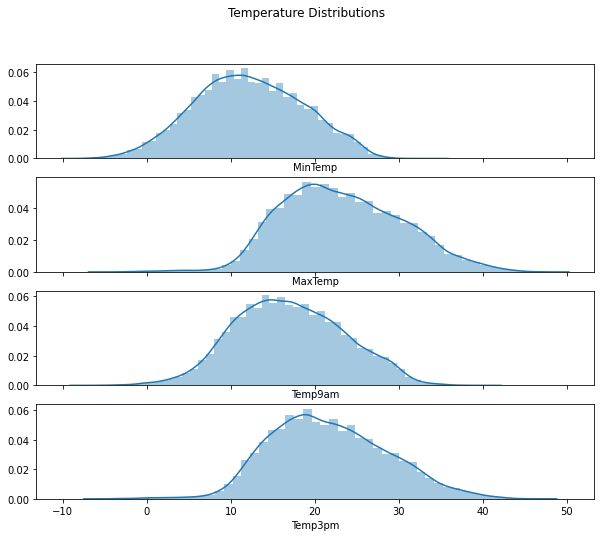

In [261]:



fig, axes = plt.subplots(4, 1, sharex = True, figsize = (10,8))
fig.suptitle("Temperature Distributions")
fig = sns.distplot(df_train['MinTemp'], ax = axes[0])
fig = sns.distplot(df_train['MaxTemp'], ax = axes[1])
fig = sns.distplot(df_train['Temp9am'], ax = axes[2])
fig = sns.distplot(df_train['Temp3pm'], ax = axes[3])
plt.show()

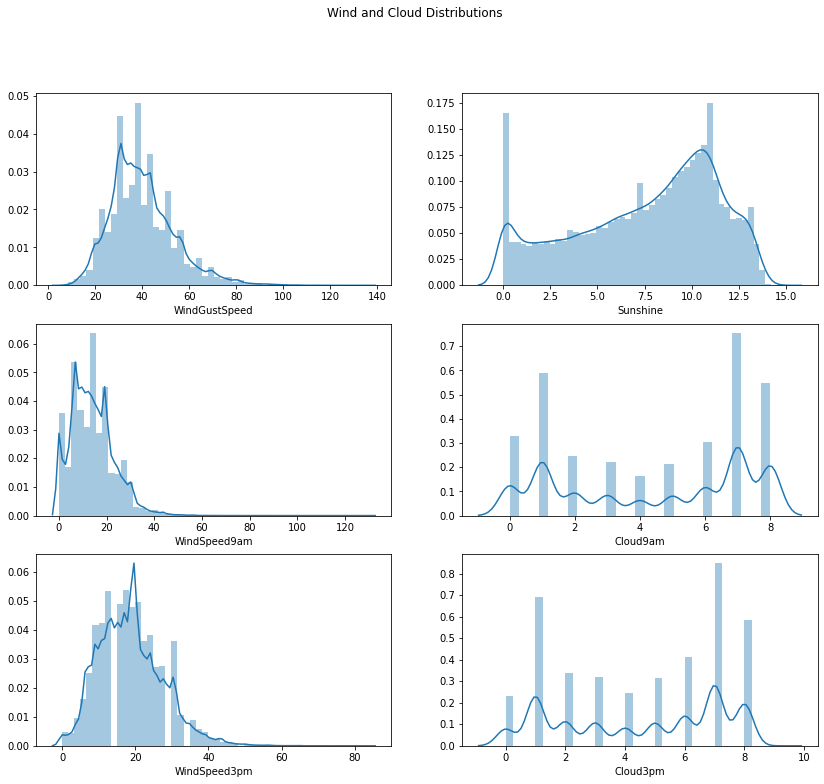

In [262]:
fig, axes = plt.subplots(3, 2, sharex = False, figsize = (14,12))
fig.suptitle("Wind and Cloud Distributions")
fig = sns.distplot(df_train['WindGustSpeed'], ax = axes[0,0])
fig = sns.distplot(df_train['WindSpeed9am'], ax = axes[1,0])
fig = sns.distplot(df_train['WindSpeed3pm'], ax = axes[2,0])
fig = sns.distplot(df_train['Sunshine'], ax = axes[0,1])
fig = sns.distplot(df_train['Cloud9am'], ax = axes[1,1])
fig = sns.distplot(df_train['Cloud3pm'], ax = axes[2,1])
plt.show()

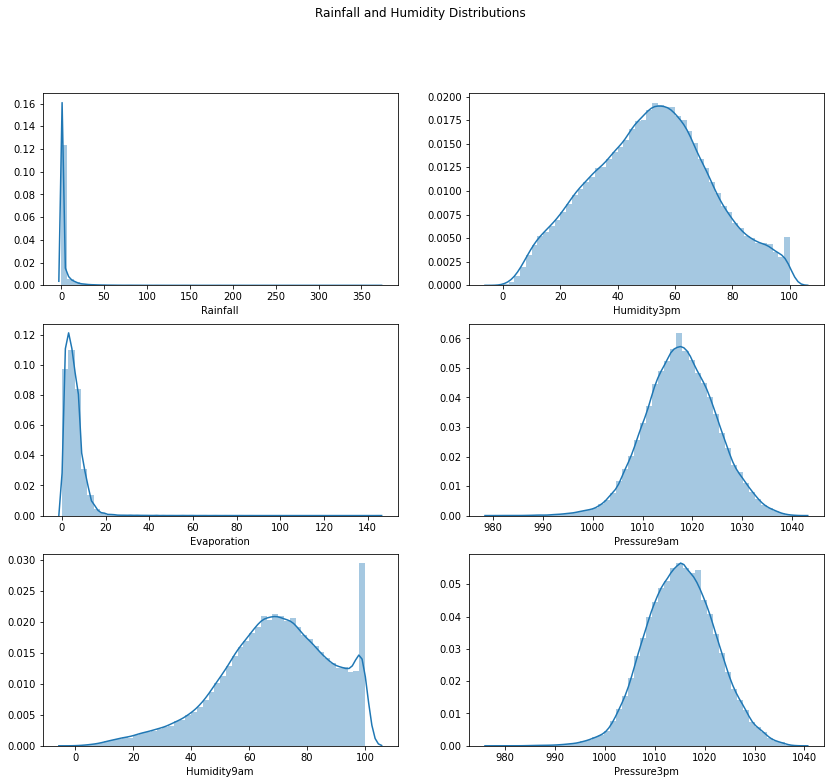

In [263]:
fig, axes = plt.subplots(3, 2, sharex = False, figsize = (14,12))
fig.suptitle("Rainfall and Humidity Distributions")
fig = sns.distplot(df_train['Rainfall'], ax = axes[0,0])
fig = sns.distplot(df_train['Evaporation'], ax = axes[1,0])
fig = sns.distplot(df_train['Humidity9am'], ax = axes[2,0])
fig = sns.distplot(df_train['Humidity3pm'], ax = axes[0,1])
fig = sns.distplot(df_train['Pressure9am'], ax = axes[1,1])
fig = sns.distplot(df_train['Pressure3pm'], ax = axes[2,1])
plt.show()

Pressure and humidity are nicely distributed with curves resembling a normal distribution. Humidity appears to max out at 100%, which leads to a spike at the highest value particularly in the 9am reading. Evaporation and Rainfall seem to be clustered in the 1 to 30 range, but there appears to be a long positive tail on both distributions. We can identify some of these unusually high readings as outliers in future sections to ensure the data is reliable.

### 2.2. Bivariate Analysis<a class="anchor" id = "2.2"></a>

Bivariate analysis involves examining relationships between the independent variables and the target(dependent variable). Features that appear to have strong correlations with the target can be selected at this stage to be used in the model.

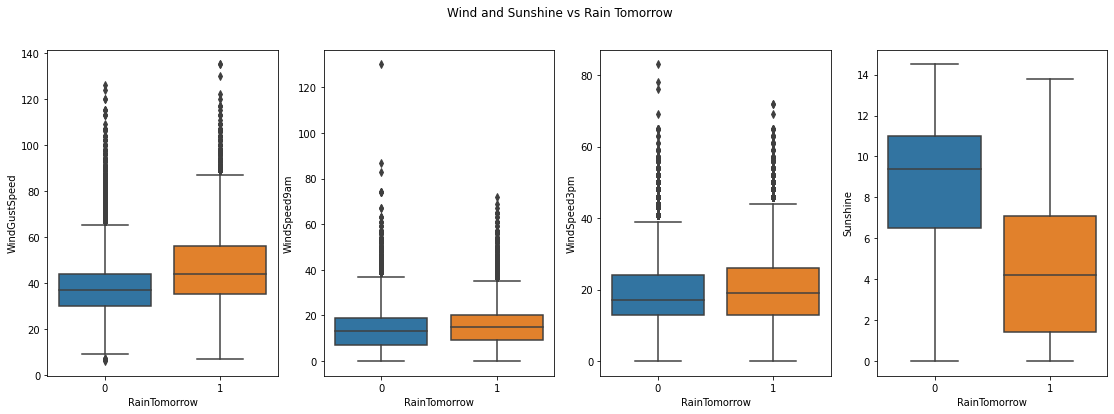

In [264]:
fig, axes = plt.subplots(1,4, sharex = False, figsize = (19,6))
fig.suptitle("Wind and Sunshine vs Rain Tomorrow")
fig = sns.boxplot(x = df_train['RainTomorrow'], y = df_train['WindGustSpeed'], ax = axes[0])
fig = sns.boxplot(x = df_train['RainTomorrow'], y = df_train['WindSpeed9am'], ax = axes[1])
fig = sns.boxplot(x = df_train['RainTomorrow'], y = df_train['WindSpeed3pm'], ax = axes[2])
fig = sns.boxplot(x = df_train['RainTomorrow'], y = df_train['Sunshine'], ax = axes[3])
plt.show()

Cloudy, windy days seem to be associated with rain the next day. This is fairly intuitive, but it bears explicitly presenting in the data to confirm our assumptions.

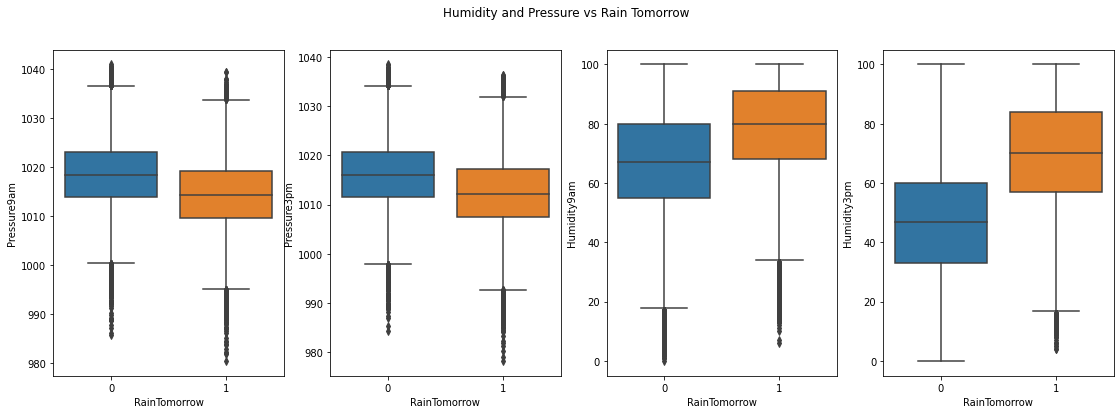

In [265]:

fig, axes = plt.subplots(1,4, sharex = False, figsize = (19,6))
fig.suptitle("Humidity and Pressure vs Rain Tomorrow")
fig = sns.boxplot(x = df_train['RainTomorrow'], y = df_train['Pressure9am'], ax = axes[0])
fig = sns.boxplot(x = df_train['RainTomorrow'], y = df_train['Pressure3pm'], ax = axes[1])
fig = sns.boxplot(x = df_train['RainTomorrow'], y = df_train['Humidity9am'], ax = axes[2])
fig = sns.boxplot(x = df_train['RainTomorrow'], y = df_train['Humidity3pm'], ax = axes[3])
plt.show()


Presure appears to be lower, and humidity seems to be higher on average the day before rain occurs.

### 2.3. Multivariate Analysis<a class="anchor" id = "2.3"></a>

For a large assessment of the features, we will run two plots: a pairplot to see any interactions between the variables, and a heatmap for a cleaner view of correlation coefficients. This step can help us identify coliniarities, and will help identify features to remove before training.

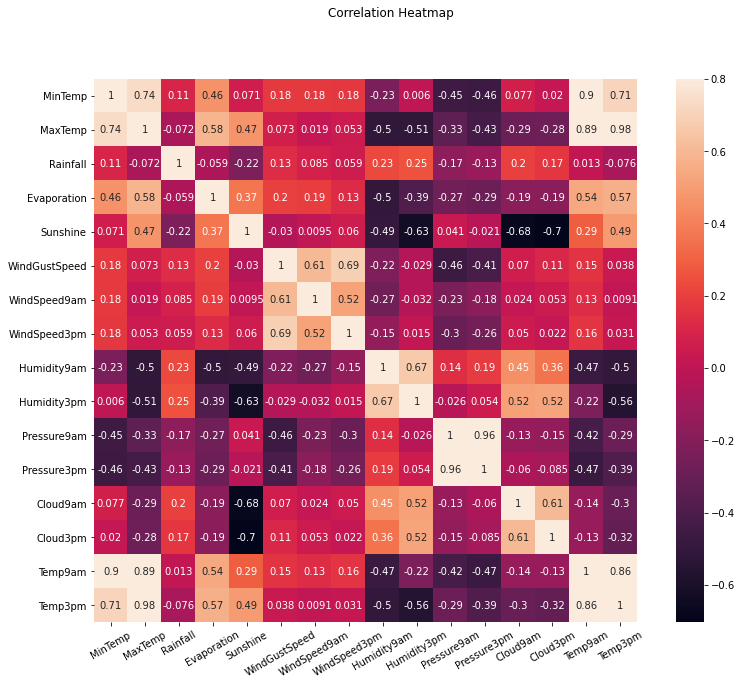

In [266]:
#correlation matrix
corrmat = df_train[numerical].corr()
fig, axes = plt.subplots(figsize=(14, 10))
fig.suptitle("Correlation Heatmap")
fig = sns.heatmap(corrmat, annot = True, vmax=.8, square=True, annot_kws={'size': 10}, yticklabels=numerical)
fig.set_xticklabels(rotation = 30, labels = numerical)
plt.show()

Some features jump out at us. We see some obvious correlations, like sunshine and clouds being negatively correlated, but also some less obvious interations. Humidity seems to be negatively corelated with MaxTemp and Sunshine. Moreover, the time of the humidity reading appears to be informative, as most other variables correlate with the two times at different strengths.

Some fields are extremely correlated (> .95), and therefore don't contribute enough to the dataset to keep them in the model. These include Temp3pm/MaxTemp (.98), and Pressure9am/Pressure3pm (.96). We will drop Temp3pm and Pressure 9am from the dataset before moving forward. 

In [267]:
X_train.drop(['Temp3pm','Pressure9am'], axis = 1, inplace = True)
X_test.drop(['Temp3pm','Pressure9am'], axis = 1, inplace = True)
df_train = pd.concat([X_train, y_train], axis = 1)

In [268]:
numerical = [n for n in numerical if n not in ['Temp3pm','Pressure9am']]
print(test_numeric)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am']


In [269]:
## Takes forever to run. commenting out for now.
# fig, axes = plt.subplots(figsize=(14, 10))
# fig = sns.pairplot(df_train[numerical].sample(n = 100))
# plt.show()

## 3. Feature Engineering<a class="anchor" id = "3"></a>

### 3.1. Numerical Feature Engineering: Missing Values and Outliers<a class="anchor" id = "3.1"></a>

Let's look at the missing data and see how well the features are recorded. If a feature has a high percentage of missing values, we have a few techniques available. We can:
    - Drop the feature column
    - Drop the rows with the missing feature's values (unwise)
    - Impute the feature, using the mean/median value (numerical) or the most common value (categorical).
    - Label these missing values as a separate category
The direction taken depends on whether the datapoints are missing completely at random, or if the missing data indicates some underlying pattern (e.g., missing wind speed might indicate a bad storm that causes the device to malfuntion). Imputation or dropping the rows can work if the missing data is randomly distributed, but it may skew the training data if there's an underlying cause.

In [270]:
# Numerical features
total = df_train[numerical].isnull().sum().sort_values(ascending=False)
percent = (df_train[numerical].isnull().sum()/df_train[numerical].isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Sunshine,47555,47.777164
Evaporation,42685,42.884413
Cloud3pm,40070,40.257196
Cloud9am,37698,37.874115
Pressure3pm,9802,9.847792
WindGustSpeed,6442,6.472095
Humidity3pm,2543,2.554880
WindSpeed3pm,1833,1.841563
Humidity9am,1231,1.236751
Rainfall,1034,1.038831


Sunshine, evaporation and cloud cover appear to have large percentages of missing data (40% - 50% missing) This is a tricky situation, because imputing a constant value here may skew the dataset, but these fields appear to be too important to drop completely (see bivariate analysis). We can impute the median value here, or set the value to zero. In some cases, imputing a column of largely missing data can be more beneficial than dropping the column completely. We will try this, but may attempt other imputation methods in future analyses (e.g., MICE and K-Nearest Neighbors methods).

In [271]:
for df in [X_train, X_test]:
    df['Pressure3pm'].fillna(X_train['Pressure3pm'].median(), inplace=True)
    df['WindSpeed9am'].fillna(X_train['WindSpeed9am'].median(), inplace=True)
    df['WindSpeed3pm'].fillna(X_train['WindSpeed3pm'].median(), inplace=True)
    df['WindGustSpeed'].fillna(X_train['WindGustSpeed'].median(), inplace=True)
    df['Humidity9am'].fillna(X_train['Humidity9am'].median(), inplace=True)
    df['Humidity3pm'].fillna(X_train['Humidity3pm'].median(), inplace=True)
    df['Temp9am'].fillna(X_train['Temp9am'].median(), inplace=True)
    df['MinTemp'].fillna(X_train['MinTemp'].median(), inplace=True)
    df['MaxTemp'].fillna(X_train['MaxTemp'].median(), inplace=True)
    df['Rainfall'].fillna(X_train['Rainfall'].median(), inplace=True)
    df['Sunshine'].fillna(X_train['Sunshine'].median(), inplace=True)
    df['Evaporation'].fillna(X_train['Evaporation'].median(), inplace=True)
    df['Cloud9am'].fillna(X_train['Cloud9am'].median(), inplace=True)
    df['Cloud3pm'].fillna(X_train['Cloud3pm'].median(), inplace=True)


In [272]:
print(numerical)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am']


In [273]:
print("Training set missing numerical values: \n" +str(X_train[numerical].isnull().sum().sort_values(ascending=False)))

print("Test set missing numerical values: \n" +str(X_test[numerical].isnull().sum().sort_values(ascending=False)))


Training set missing numerical values: 
Temp9am          0
Cloud3pm         0
Cloud9am         0
Pressure3pm      0
Humidity3pm      0
Humidity9am      0
WindSpeed3pm     0
WindSpeed9am     0
WindGustSpeed    0
Sunshine         0
Evaporation      0
Rainfall         0
MaxTemp          0
MinTemp          0
dtype: int64
Test set missing numerical values: 
Temp9am          0
Cloud3pm         0
Cloud9am         0
Pressure3pm      0
Humidity3pm      0
Humidity9am      0
WindSpeed3pm     0
WindSpeed9am     0
WindGustSpeed    0
Sunshine         0
Evaporation      0
Rainfall         0
MaxTemp          0
MinTemp          0
dtype: int64


### 3.2. Categorical Feature Engineering: Missing Values and One-hot enoding<a class="anchor" id = "3.2"></a>

In [274]:
## category missing values

total = df_train[categorical].isnull().sum().sort_values(ascending=False)
percent = (df_train[categorical].isnull().sum()/df_train[categorical].isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
WindDir9am,7018,7.050786
WindGustDir,6489,6.519315
WindDir3pm,2634,2.646305
Weekday,0,0.000000
Location,0,0.000000


This is a small amount of missing data. Under the assumption that it is missing completely at random, we will impute a replacement using the most common category value *from the training set*, applied to both training and test sets.

In [275]:
for df in [X_train, X_test]:
    df['WindGustDir'].fillna(X_train['WindGustDir'].mode()[0], inplace=True)
    df['WindDir9am'].fillna(X_train['WindDir9am'].mode()[0], inplace=True)
    df['WindDir3pm'].fillna(X_train['WindDir3pm'].mode()[0], inplace=True)
    df['RainToday'].fillna(X_train['RainToday'].mode()[0], inplace=True)

In [276]:
print("Training set missing categorical values: \n" +str(X_train[categorical].isnull().sum().sort_values(ascending=False)))
print("Test set missing categorical values: \n" +str(X_test[categorical].isnull().sum().sort_values(ascending=False)))


Training set missing categorical values: 
Weekday        0
WindDir3pm     0
WindDir9am     0
WindGustDir    0
Location       0
dtype: int64
Test set missing categorical values: 
Weekday        0
WindDir3pm     0
WindDir9am     0
WindGustDir    0
Location       0
dtype: int64


Next we will encode the categorical variables and combine the results. We will use dummy encoding, which is breaking the categorical field into k-1 binary fields, where k is the number of unique categories. The first category is removed as this information is already present whe all other categories are "0".


In [277]:
print("Training set dimensions before dummy encoding: \n" + str(X_train.shape))

X_first_train = pd.concat([X_train[numerical],
                     pd.get_dummies(X_train.Location, prefix='Loc', drop_first = True), 
                     pd.get_dummies(X_train.WindGustDir, prefix='WGD', drop_first = True),
                     pd.get_dummies(X_train.WindDir9am, prefix='WDa', drop_first = True),
                     pd.get_dummies(X_train.WindDir3pm, prefix='WDp', drop_first = True),
                     pd.get_dummies(X_train.Weekday, prefix='Week', drop_first = True),
                     X_train[['RainToday','Month','Day','Year']]], axis = 1)

print("Training set dimensions after dummy encoding: \n" + str(X_first_train.shape))

Training set dimensions before dummy encoding: 
(99535, 23)
Training set dimensions after dummy encoding: 
(99535, 117)


And the same for the test set

In [278]:
print("Test set dimensions before dummy encoding: \n" + str(X_test.shape))

X_first_test = pd.concat([X_test[numerical],
                     pd.get_dummies(X_test.Location, prefix='Loc', drop_first = True), 
                     pd.get_dummies(X_test.WindGustDir, prefix='WGD', drop_first = True),
                     pd.get_dummies(X_test.WindDir9am, prefix='WDa', drop_first = True),
                     pd.get_dummies(X_test.WindDir3pm, prefix='WDp', drop_first = True),
                     pd.get_dummies(X_test.Weekday, prefix='Week', drop_first = True),
                     X_test[['RainToday','Month','Day','Year']]], axis = 1)

print("Test set dimensions after dummy encoding: \n" + str(X_first_test.shape))

Test set dimensions before dummy encoding: 
(42658, 23)
Test set dimensions after dummy encoding: 
(42658, 117)


At this point, distance based models (SVM, Regression models) that rely on Euclidean distance would need the features to be normalized to the same range. Since Random Forest is a tree based model, scaling of the independent variables is not necessary and does not impact the model's performance, Therefore, we will move on to training. 

## 4. Model Training and Output<a class="anchor" id = "4"></a>

For the sake of this analysis, we will run the prepared data through a random forest model and determine how well it performs.

In [279]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(
    RandomForestClassifier(n_jobs=4, 
    verbose=True, 
    n_estimators=200, 
    max_depth=10, 
    criterion='gini', )
)

model.fit(X_first_train, y_train)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   14.4s finished


Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=4,
                                        oob_score=False, random_state=None,
                                        verbose=True, warm_start=False))],
         verbose=False)

## 5. Model Performance Assessment<a class="anchor" id = "5"></a>

### 5.1. Accuracy vs Recall vs Specificity<a class="anchor" id = "5.1"></a>

In [280]:
model.score(X_first_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished


0.8512181644647612

In [281]:
model.score(X_first_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished


0.8393736227671246

The model does pretty well at predicting the rain. In addition, the test performance doesn't vary much from the training performance, suggesting that overfitting isn't an issue.

For datasets with an imbalanced target class, calculating the f1 score (harmonic mean of precision and recall) will help identify if the models rely too much on accuracy at the cost of a high false positive rate.

As a basline for comparison, we can assess the model's accuracy compared to the '*null accuracy*'. The null accuracy is if the model only selects the majority class for all outcomes, which in this case is 'No' rain. This results in the following scores:

In [282]:
## Null Accuracy
print("Training set null accuracy: "+ str(1 -round(y_test.sum()/len(y_test),4)) + "\n")
print("Test set null accuracy: "+ str(1 -round(y_test.sum()/len(y_test),4)) +"\n")

Training set null accuracy: 0.7767

Test set null accuracy: 0.7767



As an alternative to accuracy, we can look at other performance metrics that highlight the abuncance of type I errors (Fale Positives) and type II errors (False Negatives). These are Recall/Sensitivity/True Positive Rate, Specificity/True Negative Rate, and Precision /Positive Predictive Value.

We can also look at the f1 score, which is the harmonic mean of Recall and Precision and assesses both types of errors in a single statistic.

In [283]:
from sklearn.metrics import f1_score

pred =  model.predict(X_first_test)
print(round(f1_score(y_test, pred),6))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
0.51266
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished


f1 score ranges from 0 (terrible) to 1 (great). 0.51 seems to be somewhere in the middle, with room for improvement. F1 is often used to compare performance between models, rather than a metric in itself. For a more interpretable score we can caluclate how well the model picks true positive values from all positives (recall) and how well the model's predicted positives turned out to be true positives (precision).

## 6. Enhancing the Dataset<a class="anchor" id = "6"></a>

The question of weather predition is a deep subfield of statistics and computational modeling. While the relatively clean and simple dataset provided for this analysis was fairly successful at predicting the right outcome, there is a wealth of data available that can provide additional context and insight to the existing dataset. For instance, a quick view of our data reveals that different weather stations have drastically different levels of rainfall, and that this rainfall can concentrate on different points in the year depending on the location. For instance, the southern, temparate regions of Western Victoria (Ballarat) vs the small Pacific Islands (Norfolk Island) vs the dense tropics of the northern coast (Darwin) vs the central desert of the outback (Uluru).  

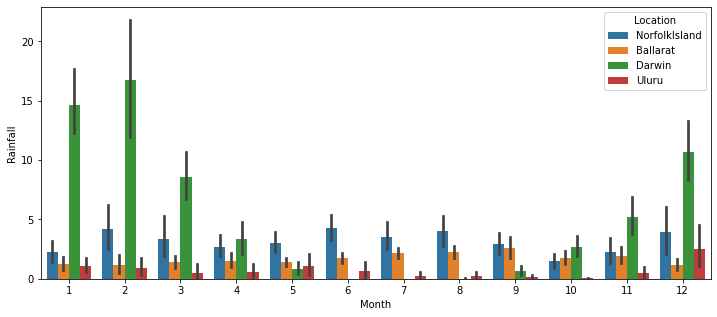

In [284]:
ex_Loc = ['Ballarat','NorfolkIsland', 'Darwin', 'Uluru']
df_graph = rawWeather[rawWeather['Location'].isin(ex_Loc)]

fig, axes = plt.subplots(figsize=(12, 5))
fig = sns.barplot(x = df_graph['Month'], y = df_graph['Rainfall'], hue = df_graph['Location'])
plt.show()

Darwin and Uluru seem to get their rain in the Summer months (Dec-Feb), but Norfolk Island and Ballarat seem to get more rain in the Winter and early Spring (Jun-Sep). The currect dataset makes no connection to topography, biome, or proximity between locations. By running a simple Geocoding tool, we can acquire latitude and longitude coordinates for each location, which can then be applied to other datasets to pull associated fields.

### 6.1. Geocoding the Locations<a class="anchor" id = "6.1"></a>

First, create clean table of locations, and a version ready for coding

In [222]:
df_location = pd.DataFrame(rawWeather['Location'].unique(), columns = ['Location'])
df_location['geoInput'] = df_location['Location'] + ', Australia'
print(df_location.head())

        Location                  geoInput
0         Albury         Albury, Australia
1  BadgerysCreek  BadgerysCreek, Australia
2          Cobar          Cobar, Australia
3   CoffsHarbour   CoffsHarbour, Australia
4          Moree          Moree, Australia


In [227]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="dmjones_eda")

# df_location['lat'] = np.nan
# df_location['lon'] = np.nan
# df_location['geoFull'] = np.nan

# for index, row in df_location.iterrows():
#     location = geolocator.geocode(row['geoInput'])
#     if location is not None:
#         df_location['geoFull'][index] = location.address
#         df_location['lat'][index] = location.latitude
#         df_location['lon'][index] = location.longitude
#         print(location.address + '... complete!')
#     else:
#         print(row['geoInput'] + ' not found..')



Albury, Albury City Council, New South Wales, 2640, Australia... complete!
BadgerysCreek, Australia not found..
Cobar, Cobar Shire Council, New South Wales, 2835, Australia... complete!
CoffsHarbour, Australia not found..
Moree, Moree Plains Shire Council, New South Wales, 2400, Australia... complete!
Newcastle, Newcastle City Council, New South Wales, 2300, Australia... complete!
NorahHead, Australia not found..
NorfolkIsland, Australia not found..
Penrith, Sydney, Penrith City Council, New South Wales, 2750, Australia... complete!
Richmond Shire, Queensland, 4822, Australia... complete!
Sydney, New South Wales, Australia... complete!
SydneyAirport, Australia not found..
WaggaWagga, Australia not found..
Williamtown, Port Stephens Council, New South Wales, 2318, Australia... complete!
Wollongong City Council, New South Wales, Australia... complete!
Canberra, District of Canberra Central, Australian Capital Territory, 2601, Australia... complete!
District of Tuggeranong, Australian Cap

In [231]:
print(df_location.isna().sum())

Location     0
geoInput     0
lat         14
lon         14
geoFull     14
dtype: int64
(49, 5)


About 14 addresses didn't return a geocode. It appears that these addresses were compound words and needed a space before the second Capitalization. Enter.. regular expressions!

In [233]:
df_location['geoCleanInput'] = df_location['geoInput'].str.replace("(?<=[a-z])(?=[A-Z])"," ", regex = True)
print(df_location['geoCleanInput'].head())

0            Albury, Australia
1    Badgerys Creek, Australia
2             Cobar, Australia
3     Coffs Harbour, Australia
4             Moree, Australia
Name: geoCleanInput, dtype: object


Perfect, let's run the code again for the rows that didn't receive a result last time.

In [239]:
# mask = df_location['geoFull'].isna()

# for index, row in df_location.iterrows():
#     if mask[index] == True:
#         location = geolocator.geocode(row['geoCleanInput'])
#         if location is not None:
#             df_location['geoFull'][index] = location.address
#             df_location['lat'][index] = location.latitude
#             df_location['lon'][index] = location.longitude
#             print(location.address + '... complete!')
#         else:
#             print(row['geoInput'] + ' not found..')

Badgerys Creek, Sydney, Liverpool City Council, New South Wales, 2555, Australia... complete!
Coffs Harbour, Coffs Harbour City Council, New South Wales, Australia... complete!
Norah Head, Central Coast Council, New South Wales, 2263, Australia... complete!
Norfolk Island, Burnt Pine, Norfolk Island, 2899, Australia... complete!
Sydney Airport, Hardie Street, Mascot, Sydney, Bayside Council, New South Wales, 2020, Australia... complete!
Wagga Wagga City Council, New South Wales, Australia... complete!
Mount Ginini, Australian Capital Territory, Australia... complete!
Melbourne Airport, Airport Drive, Melbourne Airport, City of Hume, Victoria, 3045, Australia... complete!
Gold Coast City, Queensland, Australia... complete!
City of Mount Gambier, South Australia, 5290, Australia... complete!
RAAF Base Pearce, Frigate Way, Bullsbrook, City Of Swan, Western Australia, Australia... complete!
Perth Airport, Great Eastern Highway, South Guildford, City of Belmont, Western Australia, 6054, Aus

In [240]:
print(df_location.isna().sum())

Location         0
geoInput         0
lat              0
lon              0
geoFull          0
geoCleanInput    0
dtype: int64


In [285]:
df_location = pd.read_csv('geoLocation.csv')
print(df_location.head())

        Location                  geoInput        lat         lon  \
0         Albury         Albury, Australia -36.080477  146.916280   
1  BadgerysCreek  BadgerysCreek, Australia -33.881667  150.744163   
2          Cobar          Cobar, Australia -31.498333  145.834444   
3   CoffsHarbour   CoffsHarbour, Australia -30.296241  153.113529   
4          Moree          Moree, Australia -29.461720  149.840715   

                                             geoFull  \
0  Albury, Albury City Council, New South Wales, ...   
1  Badgerys Creek, Sydney, Liverpool City Council...   
2  Cobar, Cobar Shire Council, New South Wales, 2...   
3  Coffs Harbour, Coffs Harbour City Council, New...   
4  Moree, Moree Plains Shire Council, New South W...   

               geoCleanInput  
0          Albury, Australia  
1  Badgerys Creek, Australia  
2           Cobar, Australia  
3   Coffs Harbour, Australia  
4           Moree, Australia  


In [286]:
print(X_train.columns)

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'RainToday', 'Month',
       'Day', 'Year', 'Weekday'],
      dtype='object')


In [341]:
## Perfect! Let's add it to the pre-dummy datasets:
X_new_train = pd.merge(X_train,df_location[['Location','lat','lon']], on = 'Location', how = 'left')
X_new_train.drop('Location', axis = 1, inplace = True)

## Perfect! Let's add it to the pre-dummy datasets:
X_new_test = pd.merge(X_test,df_location[['Location','lat','lon']], on = 'Location', how = 'left')
X_new_test.drop('Location', axis = 1, inplace = True)

### 6.3 Wind direction encoding<a class="anchor" id = "6.3"></a>

The dataset also contains a set of wind direction features, which are encoded as categorical strings of the directions. While this is a useful format for reading a table, it makes no connection between the values of the directions (e.g., Is a 'NW' wind closer to 'S' or 'N'?). To address this, let's encode the direction categories as angles in radians. A break in the direction range is needed, and we will start by determining North as 0 and South as the break on -/+ pi.

In [305]:
## first, find the most common wind direction
# windList = ['WindGustDir','WindDir9am','WindDir3pm']
print(sorted(X_train['WindGustDir'].unique() ))
print(sorted(X_train['WindDir9am'].unique()))
print(sorted(X_train['WindDir3pm'].unique()))

['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']
['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']
['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']


In [319]:
import math
degrees = {'direction' : ['N','NNE', 'NE', 'ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW'],
   'degrees' : [0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 202.5,180, 225, 247.5, 270, 292.5, 315, 337.5]}
df_degrees = pd.DataFrame(degrees)
df_degrees['radians'] = df_degrees['degrees']*math.pi/180
print(df_degrees.head())

  direction  degrees   radians
0         N      0.0  0.000000
1       NNE     22.5  0.392699
2        NE     45.0  0.785398
3       ENE     67.5  1.178097
4         E     90.0  1.570796


In [342]:
X_new_train = pd.merge(X_new_train,df_degrees[['direction','radians']], left_on = 'WindGustDir', right_on = 'direction', how = 'left')
X_new_train = X_new_train.rename(columns = {"radians":"WindGustDirRad"})
X_new_train.drop(['WindGustDir','direction'], axis = 1, inplace = True)

X_new_train = pd.merge(X_new_train,df_degrees[['direction','radians']], left_on = 'WindDir9am', right_on = 'direction', how = 'left')
X_new_train = X_new_train.rename(columns = {"radians":"WindDir9amRad"})
X_new_train.drop(['WindDir9am','direction'], axis = 1, inplace = True)

X_new_train = pd.merge(X_new_train,df_degrees[['direction','radians']], left_on = 'WindDir3pm', right_on = 'direction', how = 'left')
X_new_train = X_new_train.rename(columns = {"radians":"WindDir3pmRad"})
X_new_train.drop(['WindDir3pm','direction'], axis = 1, inplace = True)
print(X_new_train.columns)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'RainToday', 'Month', 'Day', 'Year', 'Weekday', 'lat', 'lon',
       'WindGustDirRad', 'WindDir9amRad', 'WindDir3pmRad'],
      dtype='object')


In [343]:
X_new_test = pd.merge(X_new_test,df_degrees[['direction','radians']], left_on = 'WindGustDir', right_on = 'direction', how = 'left')
X_new_test = X_new_test.rename(columns = {"radians":"WindGustDirRad"})
X_new_test.drop(['WindGustDir','direction'], axis = 1, inplace = True)

X_new_test = pd.merge(X_new_test,df_degrees[['direction','radians']], left_on = 'WindDir9am', right_on = 'direction', how = 'left')
X_new_test = X_new_test.rename(columns = {"radians":"WindDir9amRad"})
X_new_test.drop(['WindDir9am','direction'], axis = 1, inplace = True)

X_new_test = pd.merge(X_new_test,df_degrees[['direction','radians']], left_on = 'WindDir3pm', right_on = 'direction', how = 'left')
X_new_test = X_new_test.rename(columns = {"radians":"WindDir3pmRad"})
X_new_test.drop(['WindDir3pm','direction'], axis = 1, inplace = True)
print(X_new_test.columns)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'RainToday', 'Month', 'Day', 'Year', 'Weekday', 'lat', 'lon',
       'WindGustDirRad', 'WindDir9amRad', 'WindDir3pmRad'],
      dtype='object')


### 6.4. New Feature analysis<a class="anchor" id = "6.4"></a>

### 6.5. New model training and output<a class="anchor" id = "6.5"></a>

In [354]:
# Recode the dummies
print("Second time, training set dimensions before dummy encoding: \n" + str(X_new_train.shape))
X_second_train = pd.concat([X_new_train[numerical],
                     X_new_train[['lat','lon']],
                     X_new_train[['WindGustDirRad','WindDir9amRad','WindDir3pmRad']],
                     pd.get_dummies(X_new_train.Weekday, prefix='Week', drop_first = True),
                     X_new_train[['RainToday','Month','Day','Year']]], axis = 1)
print("Training set dimensions after dummy encoding: \n" + str(X_second_train.shape))

Second time, training set dimensions before dummy encoding: 
(99535, 24)
Training set dimensions after dummy encoding: 
(99535, 29)


In [355]:
print("Second time, testing set dimensions before dummy encoding: \n" + str(X_new_test.shape))
X_second_test = pd.concat([X_new_test[numerical],
                     X_new_test[['lat','lon']],
                     X_new_test[['WindGustDirRad','WindDir9amRad','WindDir3pmRad']],
                     pd.get_dummies(X_new_test.Weekday, prefix='Week', drop_first = True),
                     X_new_test[['RainToday','Month','Day','Year']]], axis = 1)
print("Testing set dimensions after dummy encoding: \n" + str(X_second_test.shape))

Second time, testing set dimensions before dummy encoding: 
(42658, 24)
Testing set dimensions after dummy encoding: 
(42658, 29)


In [356]:
## same model as before, trained on this dataset
model.fit(X_second_train, y_train)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   13.7s finished


Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=4,
                                        oob_score=False, random_state=None,
                                        verbose=True, warm_start=False))],
         verbose=False)

In [357]:
model.score(X_second_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished


0.8695534234188979

In [358]:
model.score(X_second_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


0.8500632941066154

In [359]:
pred =  model.predict(X_second_test)
print(round(f1_score(y_test, pred),6))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
0.574847
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


## 7. Conclusions and Future Directions<a class="anchor" id = "7"></a>

Model does performs a whole percentage point better with some small additions and transformations to the dataset. Further additions from geocoding may enhance the performance further. Additional features, such as altitude, biome, and recent presence of a wildfire may have even greater impact.